In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import tikzplotlib
import json
from scipy.stats import norm
from statistics import mean, median
from collections import Counter

In [2]:
color0 = [0.12156862745098,0.466666666666667,0.705882352941177]
color1 = [1,0.498039215686275,0.0549019607843137]

In [3]:
def k_complexity(k, n=20):
    return min(k, n) * k_complexity(k, n-1) if n > 1 else 1

In [4]:
data = {}

with open('../data/multiconfres_knums.json', 'r') as datafile:
    data = json.load(datafile)

def get_k_nums(data: dict):
    return [entry['k_num'] for entry in data['entries']]

def flatten(matrix: list) -> list:
    return [value for row in matrix for value in row]

def max_k_nums(k_nums: list) -> list:
    return [max(k) for k in k_nums]

def k_dataframe(k_nums: list):
    freq = Counter(max_k_nums(k_nums))
    df = pd.DataFrame({'k-limit': freq.keys(), 'count': freq.values()})
    
    k_limits = list(df['k-limit'])
    
    for k in range(min(k_limits), max(k_limits)):
        if k not in k_limits:
            df = df.append({'k-limit': k, 'count': 0}, ignore_index=True)
    
    df = df.sort_values(by='k-limit').reset_index()
    df['k-complexity'] = df['k-limit'].apply(k_complexity)
    df['ratio'] = df['count'].div(df['count'].sum())
    df['percentage'] = df['ratio'].mul(100)
    df['cum_ratio'] = df['ratio'].cumsum()
    df['Solutions (%)'] = df['percentage'].cumsum()
    
    return df

berlin = data['berlin']
hamburg = data['hamburg']
munchen = data['munchen']

berlin_k_nums = get_k_nums(berlin)
hamburg_k_nums = get_k_nums(hamburg)
munchen_k_nums = get_k_nums(munchen)

all_k_nums = flatten([berlin_k_nums, hamburg_k_nums, munchen_k_nums])

berlin_df = k_dataframe(berlin_k_nums)
hamburg_df = k_dataframe(hamburg_k_nums)
munchen_df = k_dataframe(munchen_k_nums)
all_df = k_dataframe(all_k_nums)

In [5]:
def tikzsave(name: str):
    tikzplotlib.save(f'../../../rapport/plots/{name}.tex')

In [6]:
def autolabel(ax, total):    
    for bar in ax.patches:
        height = bar.get_height()
        percentage = math.ceil(height/total*1000-0.5)/10
        txt = '\\Large %.1f\\%%' % percentage
        if percentage > 0.0:
            ax.text(bar.get_x() + bar.get_width()/2., 1.05*height, txt,
                    ha='center', va='bottom', fontsize=12)
        
def autolabelh(ax, total):    
    for bar in ax.patches:
        width = bar.get_width()
        percentage = math.ceil(width/total*1000-0.5)/10
        txt = '\\Large %.1f\\%%' % percentage
        if percentage > 0.0:
            ax.text(width+.3, bar.get_y() + bar.get_height()/2., txt,
                    ha='left', va='center', fontsize=12)

In [7]:
def print_stats(data: dict):
    print('median:', int(data['k_median']))
    print('mean:', data['k_mean'])
    print('min:', data['k_min'])
    print('max:', data['k_max'])
    print('variance:', data['k_variance'])
    print('stdev:', data['k_stdev'])

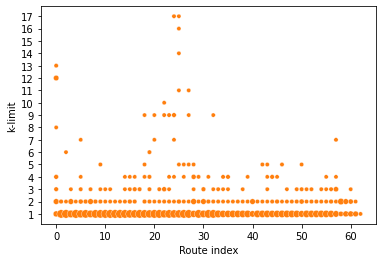

In [8]:
def scatter(k_nums: list):
    df = pd.DataFrame({
        'k-limit': flatten(k_nums),
        'route_idx': [index for row in k_nums for index, _ in enumerate(row)]
    })
    dfg = df.groupby(df.columns.tolist()).size().reset_index().rename(columns={0:'records'})

    fig, ax = plt.subplots()
    sns.scatterplot(x='route_idx', y='k-limit', size='records', data=dfg, ax=ax, color=color1, legend=False)
    ax.set_yticks(np.arange(1, df['k-limit'].max()+1, 1.0))
    plt.ylabel('k-limit')
    plt.xlabel('Route index')
    
scatter(all_k_nums)

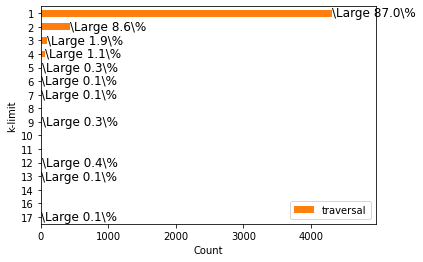

In [9]:
def bar_chart_choice(k_nums: list):
    values = flatten(k_nums)
    freq = Counter(values)
    df = pd.DataFrame({'k-limit': freq.keys(), 'traversal': freq.values()})
    df = df.sort_values(by=['k-limit'])
    
    fig, ax = plt.subplots()
    df.plot.barh(x='k-limit', y='traversal', ax=ax, color=color1)
    autolabelh(ax, df['traversal'].sum())
    ax.invert_yaxis()
    ax.legend(['traversal'], loc='lower right')
    plt.xlim(0, df['traversal'].sum())
    plt.xlabel('Count')
    
bar_chart_choice(all_k_nums)

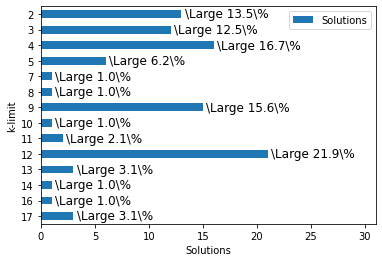

In [10]:
def bar_chart(k_nums: list):
    values = max_k_nums(k_nums)
    freq = Counter(values)
    df = pd.DataFrame({'k-limit': freq.keys(), 'solutions': freq.values()})
    df = df.sort_values(by=['k-limit'])
    
    fig, ax = plt.subplots()
    df.plot.barh(x='k-limit', y='solutions', ax=ax)
    autolabelh(ax, df['solutions'].sum())
    plt.xlim(0,df['solutions'].max()+10)
    plt.xlabel('Solutions')
    legend = ax.legend(['Solutions'],loc='upper right')
    ax.invert_yaxis()
            
bar_chart(all_k_nums)

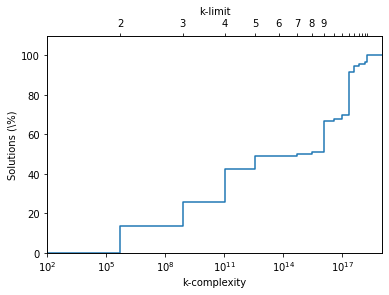

In [11]:
def step_chart(df):
    max_k = df['k-limit'].max()
    max_complexity = k_complexity(max_k)
    x_limit = 10**math.ceil(math.log10(max_complexity))
    df = df.append([
        {'k-complexity': 0.1, 'k-limit': 0, 'count': 0, 'Solutions (%)': 0},
        {'k-complexity': x_limit, 'k-limit': max_k+1, 'count': 0, 'Solutions (%)': 100}
    ], ignore_index=True).reset_index()
    
    fig, ax = plt.subplots()    
    sns.lineplot(x='k-complexity', y='Solutions (%)', data=df, ax=ax, drawstyle='steps-post')
    plt.ylim(0,110)
    plt.xlim(100,df['k-complexity'].max())
    plt.xscale('log')
    plt.xlabel('k-complexity')
    plt.ylabel('Solutions (\\%)')
    
    k_comps = [k_complexity(k) for k in range(2, df['k-limit'].max())]
            
    ax2 = ax.twiny()
    ax2.set_xscale('log')
    ax2.set_xticks(k_comps)
    ax2.set_xticklabels([index+2 if index < 8 else None for index, _ in enumerate(k_comps)])
    ax2.set_xlim(100,df['k-complexity'].max())
    ax2.set_xlabel('k-limit')
    
step_chart(all_df)

,k-limit,Solutions (%),Attractiveness
1,3,26.041667,1.000000
2,4,42.708333,0.983024
0,2,13.541667,0.952519
3,5,48.958333,0.804297
4,6,48.958333,0.609914
5,7,50.000000,0.463133
6,8,51.041667,0.344820
7,9,66.666667,0.326367
8,10,67.708333,0.242953
9,11,69.791667,0.178228


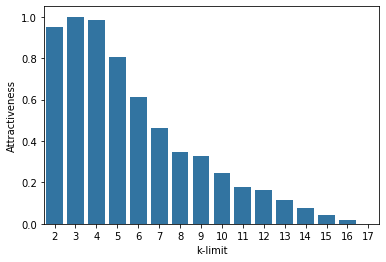

In [12]:
def best_k_limit(df):
    max_k = df['k-limit'].max()
    max_complexity = math.log10(k_complexity(max_k))
    max_dist = math.sqrt(2)
    
    df['norm_comp'] = df['k-complexity'].apply(math.log10).div(max_complexity)
    
    df['distance'] = [calc_dist(row) if row['cum_ratio'] > 0 else max_dist for _, row in df.iterrows()]
    df['points'] = df['distance'].apply(lambda x: (max_dist-x)/max_dist)
    df['Attractiveness'] = df['points'].sub(df['points'].min()).div(df['points'].max()-df['points'].min())
    df = df.query(f'`k-limit` > 0 & `k-limit` <= {max_k}')
    
    fig, ax = plt.subplots()
    sns.barplot(x='k-limit', y='Attractiveness', color=color0, ax=ax, data=df)
    
    return df.sort_values(by='distance').filter(['k-limit', 'Solutions (%)', 'Attractiveness'])


w_x = 1
w_y = 0.5

def calc_dist(row):
    x = row['norm_comp']**w_x
    y = row['cum_ratio']**w_y
    return math.sqrt(x**2 + (1-y)**2)

best_k_limit(all_df)

## Berlin

In [13]:
print_stats(berlin)

median: 1
mean: 1.1430030643513789
min: 1
max: 5
variance: 0.2176592447529964
stdev: 0.4665396497115721


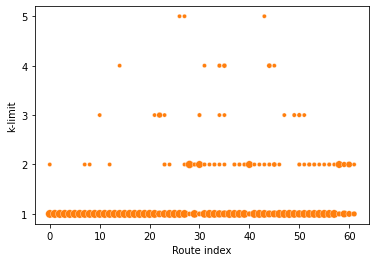

In [14]:
scatter(berlin_k_nums)
# tikzsave("scatter_berlin_k_nums")

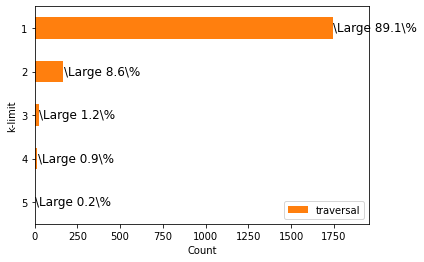

In [15]:
bar_chart_choice(berlin_k_nums)
tikzsave("choice_berlin_k_nums")

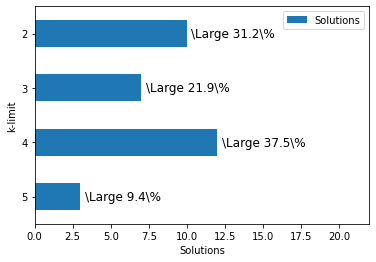

In [16]:
bar_chart(berlin_k_nums)
tikzsave("bar_berlin_k_nums")

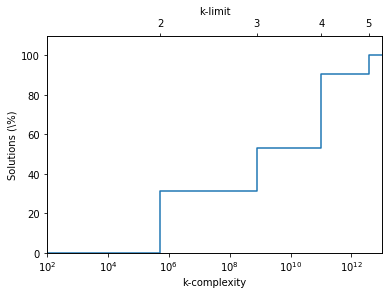

In [17]:
step_chart(berlin_df)
tikzsave("step_berlin_k_nums")

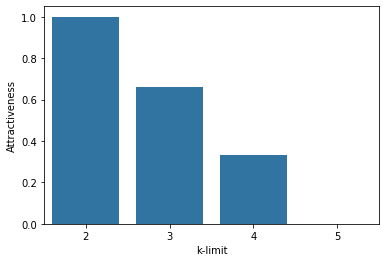

In [18]:
best_k_limit(berlin_df)
tikzsave("att_berlin")

## Hamburg

In [19]:
print_stats(hamburg)

median: 1
mean: 1.427767354596623
min: 1
max: 17
variance: 2.4797540716468918
stdev: 1.57472349053632


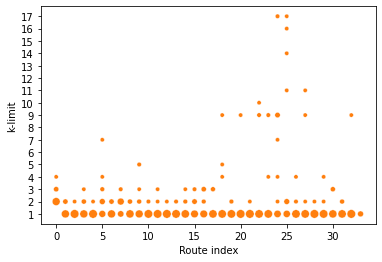

In [20]:
scatter(hamburg_k_nums)
# tikzsave("scatter_hamburg_k_nums")

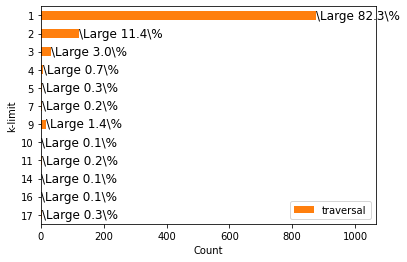

In [21]:
bar_chart_choice(hamburg_k_nums)
tikzsave("choice_hamburg_k_nums")

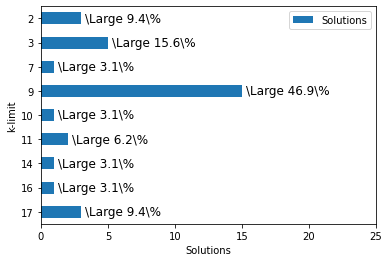

In [22]:
bar_chart(hamburg_k_nums)
tikzsave("bar_hamburg_k_nums")

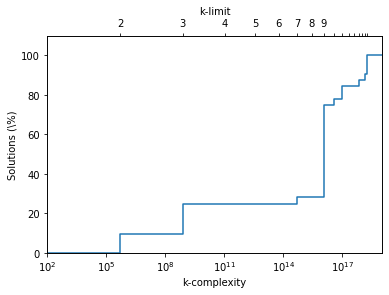

In [23]:
step_chart(hamburg_df)
tikzsave("step_hamburg_k_nums")

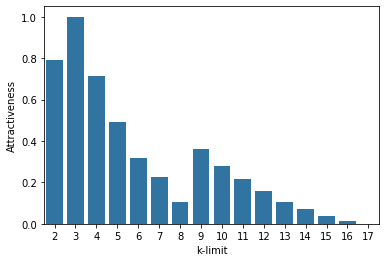

In [24]:
best_k_limit(hamburg_df)
tikzsave("att_hamburg")

## München

In [25]:
print_stats(munchen)

median: 1
mean: 1.3300670448684888
min: 1
max: 13
variance: 1.9013194485470417
stdev: 1.3788834064369047


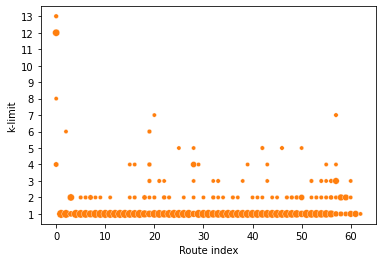

In [26]:
scatter(munchen_k_nums)
# tikzsave("scatter_munchen_k_nums")

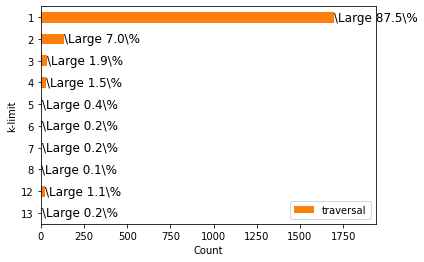

In [27]:
bar_chart_choice(munchen_k_nums)
tikzsave("choice_munchen_k_nums")

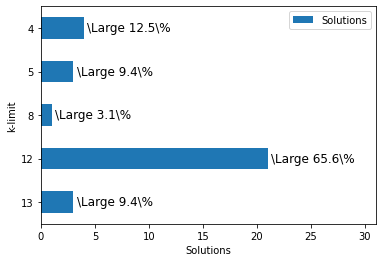

In [28]:
bar_chart(munchen_k_nums)
tikzsave("bar_munchen_k_nums")

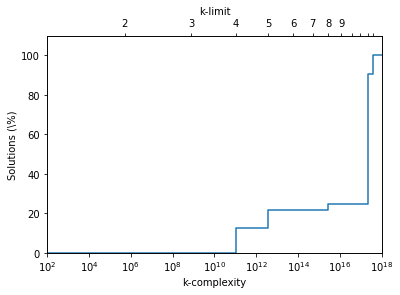

In [29]:
step_chart(munchen_df)
tikzsave("step_munchen_k_nums")

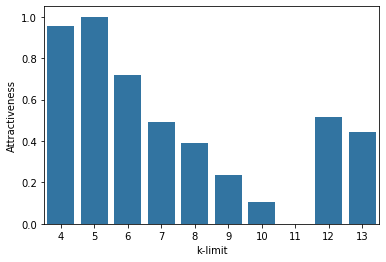

In [30]:
best_k_limit(munchen_df)
tikzsave("att_munchen")

## All

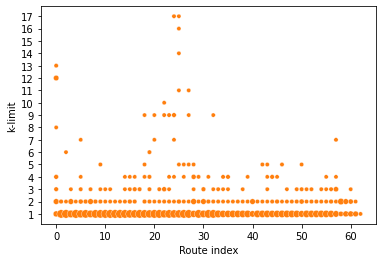

In [31]:
scatter(all_k_nums)
# tikzsave("scatter_all_k_nums")

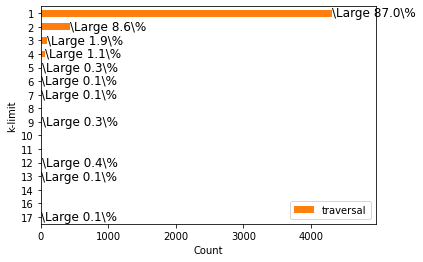

In [32]:
bar_chart_choice(all_k_nums)
tikzsave("choice_all_k_nums")

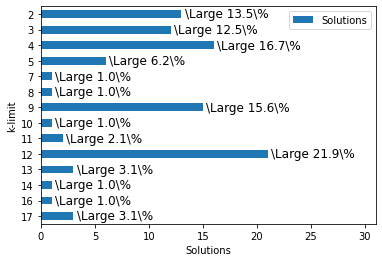

In [33]:
bar_chart(all_k_nums)
tikzsave("bar_all_k_nums")

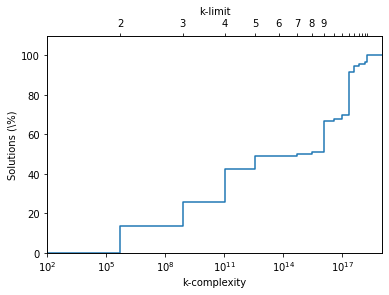

In [34]:
step_chart(all_df)
tikzsave("step_all_k_nums")

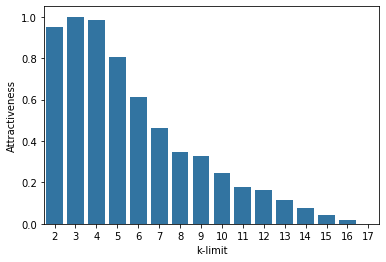

In [35]:
best_k_limit(all_df)
tikzsave("att_all")